# Parameters

In [1]:
total_files = 1
temporary_storage='/content/temporary'
storage = 'onelake'

 **OneLake Configuration**
it is a one off operation to get Onelake credential, Fivetran has an excellent setup guide
https://fivetran.com/docs/destinations/onelake/setup-guide

In [2]:
match storage:
 case 'local':
  storage_options={"allow_unsafe_rename":"true"}
  lakehouse =     '/lakehouse/default/Tables/'
 case 'onelake':
  !pip install -q azure-identity
  from azure.identity import ClientSecretCredential, AuthenticationRequiredError
  from google.colab import userdata
  credential = ClientSecretCredential(
                client_id=userdata.get("appId"),
                client_secret=userdata.get("secret"),
                tenant_id=userdata.get ("tenantId")
                )
  access_token =       credential.get_token("https://storage.azure.com/.default").token
  storage_options=     {"bearer_token": access_token, "use_fabric_endpoint": "true"}
  ### lakehouse path is something like this : "abfss://workspace@onelake.dfs.fabric.microsoft.com/Lakehousename.Lakehouse/Tables/"
  lakehouse =           userdata.get("table_path_onelake")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 11.1 MB/s eta 0:00:00


***Install Package***

In [ ]:
!pip install   -q duckdb  --upgrade
!pip install   -q pyarrow --upgrade
!pip install   -q polars  --pre --upgrade
!pip install   -q 'ibis-framework' --upgrade
!pip install   -q deltalake
!pip install   -q getdaft

In [4]:
# @title
from psutil import *
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:13.0


# Download Data

In [5]:
# @title
import re ,os
import requests
from urllib.request import urlopen
def download(url,Path):
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = list(set(filelist1))[:total_files]
    print(str(len(filelist_unique)) + ' New File Loaded')
    if len(filelist_unique) != 0 :
      for x in filelist_unique:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
    return "done"

In [6]:
# @title
from shutil import unpack_archive
import os , glob
def unzip(Source, Destination):
    filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    for x in filelist:
          try:
            unpack_archive(str(Source+x), str(Destination), 'zip')
          except:
            pass
    return "done"

In [7]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",temporary_storage+"/zip/")
unzip(temporary_storage+"/zip/",temporary_storage+"/csv/")

1 New File Loaded


'done'

#-----

# DuckDB

In [8]:
# @title
import duckdb
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)
	columns = list(set(raw.columns) - {'SETTLEMENTDATE','DUID','I','filename','UNIT'})
	exprs = [
		duckdb.ColumnExpression(x).cast(duckdb.typing.DOUBLE).alias(x)
		for x in columns
	         ]
	rel2 = raw.select('SETTLEMENTDATE','DUID','I','filename','UNIT',*exprs)

	scada=duckdb.sql(""" select *exclude(SETTLEMENTDATE,I,XX,filename),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as YEAR  from rel2  """)
	return scada.arrow()


# Polars

In [9]:
# @title
import polars as pl
def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x,
                    skip_rows=1,
                    schema=schema,
                    has_header=False,
                    truncate_ragged_lines=True)
  transform =(
      raw
      .filter(pl.col("I")=='D')
      .filter(pl.col("UNIT")=='DUNIT')
      .filter(pl.col("VERSION")=='3')
      .drop("XX")
      .drop("I")
  )
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE','DUID','UNIT'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),YEAR=pl.col("SETTLEMENTDATE").dt.iso_year()).collect()
  return final.to_arrow()

# Pandas

In [10]:
import pandas as pd

def Pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['YEAR'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    return appended_data

# Ibis

In [11]:
# @title
import ibis
def ibis_clean_csv(files_to_upload_full_Path):
 schema={
			'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
			'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
			'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
			'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
			'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
			'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
			'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
			'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
			'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
			'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
			'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
			'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
			'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
			'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
			'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
			'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'}
 raw = ibis.read_csv(files_to_upload_full_Path,Skip=1,header =0,all_varchar=1,columns =schema,filename =1,null_padding = 1,ignore_errors=1,auto_detect=0)
 DUNIT = raw.filter((raw.UNIT == "DUNIT") & (raw.VERSION  == '3') & (raw.I  == 'D')).drop("XX","I")
 DUNIT = DUNIT.cast({"SETTLEMENTDATE": "timestamp"})
 DUNIT = DUNIT.mutate(
      date=DUNIT.SETTLEMENTDATE.cast("date"),
      year=DUNIT.SETTLEMENTDATE.year(),
  )
 df_cols = list(set(DUNIT.columns) - {'SETTLEMENTDATE','DUID','filename','UNIT','date','year'})
 for col_name in df_cols:
      DUNIT = DUNIT.cast({col_name: "double"})
 return DUNIT.to_pyarrow()

# Pyarrow

In [12]:
# work in Progress
from pyarrow import csv
import pyarrow.compute as pc
import pyarrow as pa
import pyarrow.dataset as ds
def pyarrow_clean_csv(files_to_upload_full_Path):
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format)
  df= raw.filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= df.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"YEAR", pc.year(df['SETTLEMENTDATE']))
  return df

# Daft

In [13]:
import daft
from daft import DataType, col
def daft_clean_csv(files_to_upload_full_Path):
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True)
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", df["SETTLEMENTDATE"].str.to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('YEAR', col('SETTLEMENTDATE').dt.year())
	return df.to_arrow()

# Run Test

In [14]:
# @title
import glob,os
Source = temporary_storage+"/csv/"
list_files=[os.path.basename(x) for x in glob.glob(Source+'*.CSV')]
files_to_upload_full_Path = [Source + i for i in list_files][:total_files]

In [15]:
# maximum nbr pf files is 60, you can customize how many files to process at one time, RAM is the bottlneck
import time
import pandas as pd
results = pd.DataFrame(columns=['Engine','step','duration'])

In [16]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= pyarrow_clean_csv(chunk)
    print('Pyarrow read CSV:' + str(time.time()-start))
    write_deltalake(lakehouse+"scada_Pyarrow",df, mode="append",partition_by=['YEAR'], storage_options=storage_options)
    print('Pyarrow total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pyarrow',i,time.time()-start]], columns=results.columns), results])

Pyarrow read CSV:2.6175270080566406
Pyarrow total:4.239688158035278
CPU times: user 2.24 s, sys: 355 ms, total: 2.6 s
Wall time: 4.3 s


In [17]:
%%time
from deltalake.writer import write_deltalake
chunk_len = 60
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= daft_clean_csv(chunk)
    print('Daft read CSV:' + str(time.time()-start))
    write_deltalake(lakehouse+"scada_Daft",df, mode="append",partition_by=['YEAR'], storage_options=storage_options)
    print('Daft total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Daft',i,time.time()-start]], columns=results.columns), results])

ScanWithTask-Project-Project [Stage:1]:   0%|          | 0/1 [00:00<?, ?it/s]

Daft read CSV:7.148796796798706
Daft total:8.545904636383057
CPU times: user 4.54 s, sys: 1.25 s, total: 5.79 s
Wall time: 8.55 s


In [18]:
%%time
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df = ibis_clean_csv(chunk)
    print('ibis read CSV:' + str(time.time()-start))
    write_deltalake(lakehouse+"scada_ibis",df, mode="append", partition_by=['year'],storage_options= storage_options)
    del df
    print('Ibis total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Ibis',i,time.time()-start]], columns=results.columns), results])

ibis read CSV:5.940378189086914
Ibis total:10.009677648544312
CPU times: user 5.25 s, sys: 419 ms, total: 5.67 s
Wall time: 10 s


In [19]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= duckdb_clean_csv(chunk)
    print('duckdb read CSV:' + str(time.time()-start))
    write_deltalake(lakehouse+"scada_DuckDB",df, mode="append", partition_by=['YEAR'],storage_options= storage_options)
    del df
    print('DuckDB total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['DuckDB',i,time.time()-start]], columns=results.columns), results])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

duckdb read CSV:2.7912325859069824
DuckDB total:4.04668116569519
CPU times: user 2.25 s, sys: 258 ms, total: 2.51 s
Wall time: 4.05 s


In [20]:
%%time
if mem > 13:
 chunk_len = total_files
else:
  chunk_len = 20
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= polars_clean_csv(chunk)
    print('polars read CSV:' + str(time.time()-start))
    write_deltalake(lakehouse+"scada_Polars",df, mode="append", partition_by=['YEAR'],storage_options=storage_options)
    del df
    print('Polars total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Polars',i,time.time()-start]], columns=results.columns), results])

polars read CSV:6.691959381103516
Polars total:10.18039846420288
CPU times: user 5.67 s, sys: 977 ms, total: 6.65 s
Wall time: 10.2 s


In [21]:
%%time
import pyarrow as pa
if mem > 13:
 chunk_len = total_files
else:
  chunk_len = 20
if len(files_to_upload_full_Path) <10 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ########################## make sure to ignore index
    start = time.time()
    df= Pandas_clean_csv(chunk)
    xx= pa.Table.from_pandas(df,preserve_index=False)
    print('Pandas read CSV:' + str(time.time()-start))
    write_deltalake(lakehouse+"scada_Pandas",xx, mode="append", partition_by=['YEAR'],storage_options=storage_options)
    del xx
    print('Pandas total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pandas',i,time.time()-start]], columns=results.columns), results])

Pandas read CSV:11.303492784500122
Pandas total:12.654213190078735
CPU times: user 9.4 s, sys: 1.68 s, total: 11.1 s
Wall time: 12.7 s


# Results

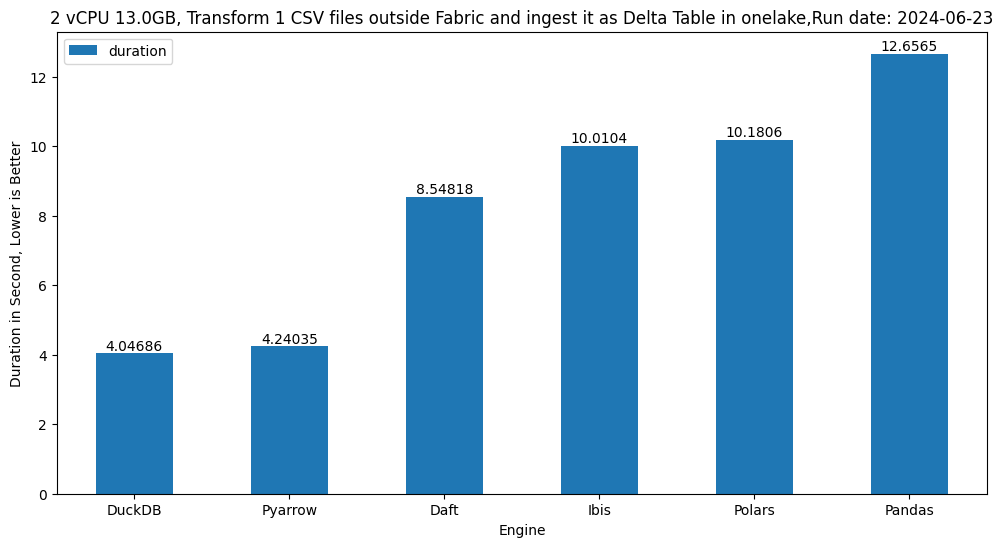

In [24]:
# @title
result = results.groupby(['Engine'])['duration'].sum().reset_index()
result = result.sort_values(by = ['duration'], ascending=[True])
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform '+ str(total_files)+f' CSV files outside Fabric and ingest it as Delta Table in {storage},Run date: '+ str(time.strftime("%Y-%m-%d"))
ax = result.plot.bar(rot=0,x='Engine',title=runtime,ylabel='Duration in Second, Lower is Better',figsize=(12,6))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')